# Analysis of the different inputs to the SOM with CNN

In [1]:
from __future__ import print_function

import tensorflow as tf
from tensorflow.python.tools import inspect_checkpoint as chkp
from tensorflow.python.platform import gfile
from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio
# boilerplate code

import os
from io import BytesIO
import numpy as np
import random
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
import matplotlib.pyplot as plt


from mpl_toolkits.mplot3d import Axes3D
import somoclu
import deep_som as ds
import time
import matplotlib.cm as cm
from pathlib import Path
import pprint, pickle

import utils

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1 - Load CNN and restore tensors

In [2]:
cnn_directory = r"C:\tmp\speech_commands_train"
checkpoint_name = "conv.ckpt-18000"
graph_name = "conv.pbtxt"
tensor_names=["MatMul", "Conv2D_1", "Conv2D"]
output_tensors={}

In [3]:
sess = utils.load_speech_command_cnn(cnn_directory, checkpoint_name)
ms = utils.init_cnn_model_settings()
output_tensors = dict(zip(tensor_names, [utils.restore_tensor(tensor_name) for tensor_name in tensor_names]))
mfcc_tensor_flatten, mfcc_tensor = utils.build_preproc_graph_for_cnn()
output_tensors["mfcc"] = mfcc_tensor


INFO:tensorflow:Restoring parameters from C:\tmp\speech_commands_train\conv.ckpt-18000


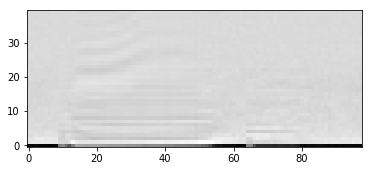

(200,)
(62720,)
(250880,)
(3920,)


In [4]:
wav_fname = r"C:\tmp\speech_dataset\dog\00f0204f_nohash_1.wav"
mfcc = sess.run(mfcc_tensor, feed_dict={"wav_data:0": wav_fname})
plt.imshow(mfcc.T.squeeze(), origin='lower', cmap='gray')
plt.show()

mfcc_flat = sess.run(mfcc_tensor_flatten, feed_dict={"wav_data:0": wav_fname})
for tn, t in output_tensors.items():
    if tn is "mfcc":
        input_dict = {"wav_data:0": wav_fname}
    else:
        input_dict = {
                  "dropout_prob:0" : 1.0,
                  "fingerprint_input:0" : mfcc_flat
                 }
    out = sess.run(t, feed_dict=input_dict)
    print(out.flatten().shape)


## 2 - Create training and test set

In [5]:

db_directory = Path(r"C:\Study\DB\SpeechCommands")
ignore_list = [
    r"C:\Study\DB\SpeechCommands\_background_noise_"
]
train_size = 10000

test_size=100

random.seed(1)
file_list = [f for f in db_directory.resolve().glob('**/*') if f.is_file() and f.suffix == '.wav'  and 
             all(ignore_obj not in str(f) for ignore_obj in ignore_list)]

random.shuffle(file_list)
train_file_list = np.array(file_list[:train_size])
train_labels = np.array([p.parent.stem for p in train_file_list])

test_file_list = np.array(file_list[train_size: train_size + test_size])
test_labels = np.array([p.parent.stem for p in test_file_list])


In [6]:
p = test_labels.argsort()
test_labels = test_labels[p]
test_file_list = test_file_list[p]

print(test_labels[:10])

activations={}

for tn, t in output_tensors.items():
    print("calculating activation for the layer ", tn)
    activations[tn] = []
    for wav_fname, label in zip(test_file_list, test_labels):
        mfcc_flat = sess.run(mfcc_tensor_flatten, feed_dict={"wav_data:0": str(wav_fname)})
        
        if tn is "mfcc":
            input_dict = {"wav_data:0": str(wav_fname)}
        else:
            input_dict = {
                      "dropout_prob:0" : 1.0,
                      "fingerprint_input:0" : mfcc_flat
                     }
        out = sess.run(t, feed_dict=input_dict)
        activations[tn].append(out.flatten())
    activations[tn] = np.array(activations[tn])
    print("shape of activations ", activations[tn].shape)

['bed' 'bed' 'bed' 'bed' 'bed' 'bird' 'bird' 'cat' 'cat' 'cat']
calculating activation for the layer  MatMul
shape of activations  (100, 200)
calculating activation for the layer  Conv2D_1
shape of activations  (100, 62720)
calculating activation for the layer  Conv2D
shape of activations  (100, 250880)
calculating activation for the layer  mfcc
shape of activations  (100, 3920)


## 3 - Plot similarity matrix for all activations

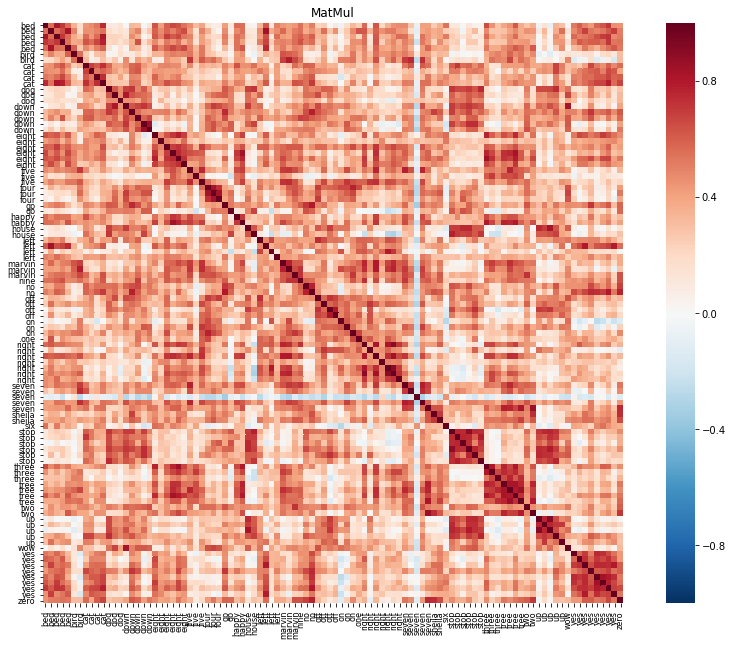

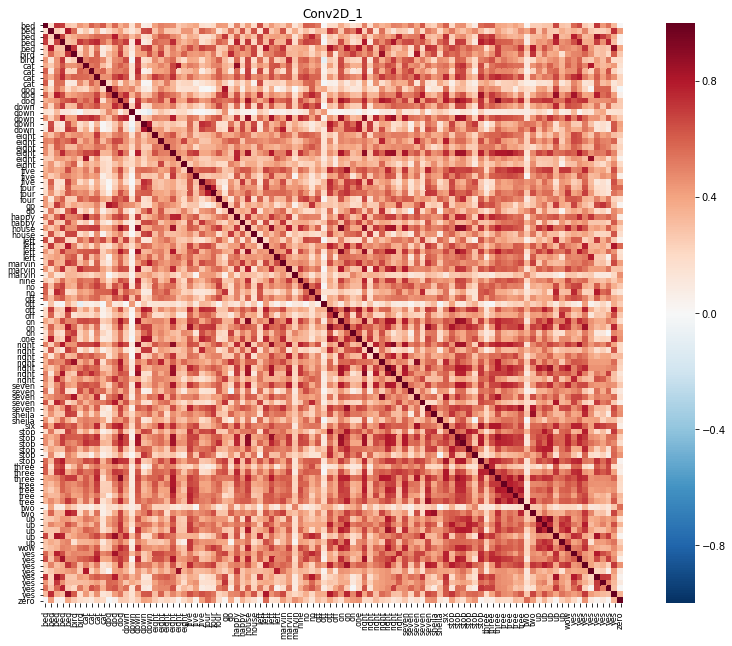

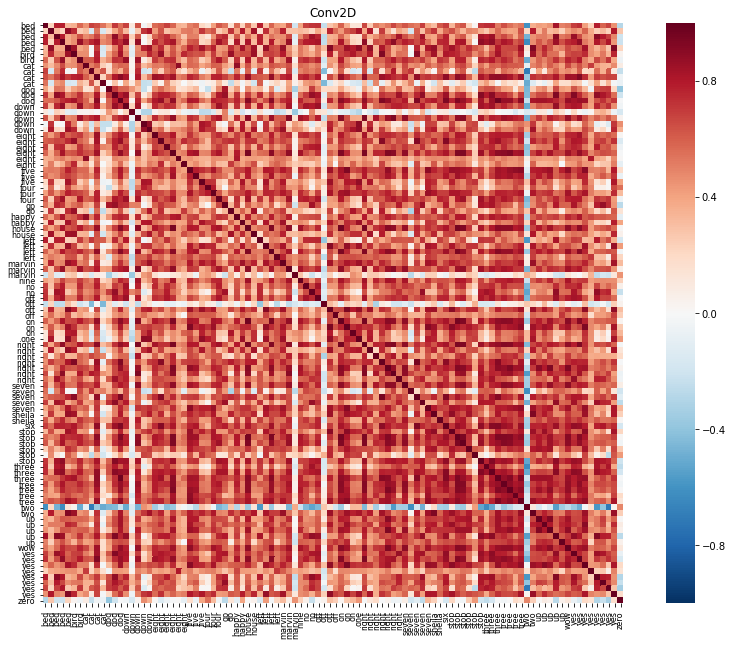

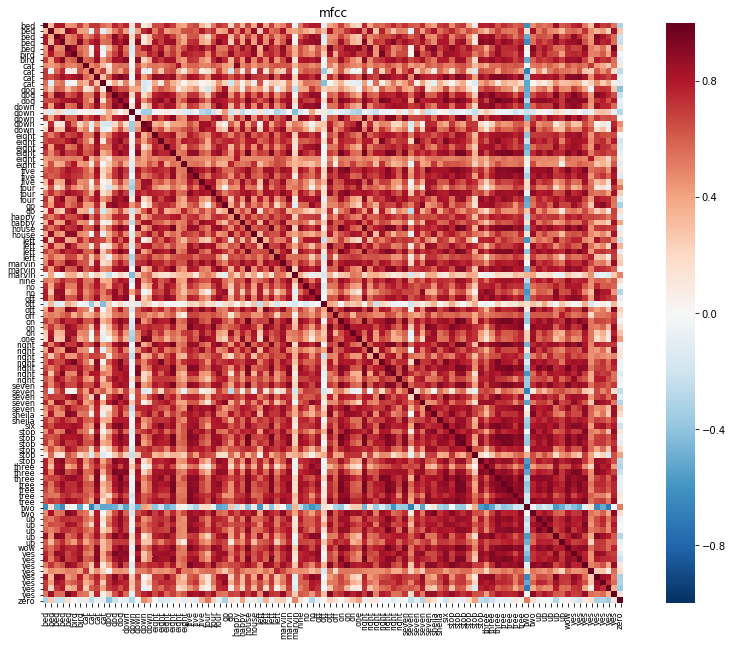

In [7]:
som = somoclu.Somoclu(1,1)
tn = "MatMul"
for tn, act in activations.items():
    plt = som.view_similarity_matrix(data=activations[tn], labels=test_labels, show=False)
    plt.title(tn)
    plt.show()